In [1]:
import sys
!{sys.executable} -m pip install mysql-connector
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import mysql.connector
from datetime import datetime
import dateutil.parser
import pylab as pla
import math

mydb = mysql.connector.connect(
  host="iiwari-mariadb-server",
  user="root",
  passwd="d41k4Duu",
  database="iiwari_org"
)

# Päivän valinta hakuun

In [ ]:
start_date = datetime(2019, 3, 7)
end_date = datetime(2020, 1, 23)

dates = pd.date_range(start_date, end_date, freq='D')

options = [(date.strftime(' %d %b %Y '), date) for date in dates]
index = (0, len(options)-1)

selection_range_slider = widgets.SelectionRangeSlider(
    options=options,
    index=index,
    description='Dates',
    orientation='horizontal',
    layout={'width': '1000px'}
)

selection_range_slider

In [ ]:
first_day = 0
last_day = 0
def print_date_range(date_range):
    global first_day
    global last_day
    #print(date_range)
    days = date_range
    print(days)
    first_day = days[0]
    last_day = days[-1]

widgets.interact(
    print_date_range,
    date_range=selection_range_slider
);

In [ ]:
first_day = str(first_day)
first_day = first_day + ".000000+00:00"

last_day = str(last_day)
last_day = last_day.strip("'00:00:00'")
last_day = last_day + " 23:59:59.000000+00:00"

print("Aloituspäivä: ", first_day,"\nLopetuspäivä: ", last_day)

In [2]:
mycursor = mydb.cursor(dictionary=True)
mycursor.execute("SELECT node_id, timestamp, x,y,z,q FROM SensorData WHERE (node_id = 51719)  AND timestamp > %s AND timestamp < %s AND x > 0  AND X < 10406 AND y < 5220 AND y > 0 AND q < 100 AND z = 0 ", (first_day,last_day));
#mycursor.execute("SELECT node_id, x, y, COUNT(node_id), timestamp FROM SensorData WHERE timestamp > '2019-01-01 13:05:08.078133+00:00' AND timestamp < '2019-01-03 13:05:08.078133+00:00' GROUP BY node_id ");
database = pd.DataFrame(mycursor.fetchall())
print(database)

In [3]:
print(database)

        node_id                            timestamp    x     y  z   q
0         51719  b'2019-10-01 13:14:10.686075+00:00'  261  1173  0  64
1         51719  b'2019-10-01 13:14:16.686502+00:00'  242  1103  0  10
2         51719  b'2019-10-01 13:14:22.686321+00:00'  613  2438  0  78
3         51719   b'2019-10-01 13:14:23.68618+00:00'  647  2559  0  51
4         51719  b'2019-10-01 13:14:24.686515+00:00'  676  2664  0  22
...         ...                                  ...  ...   ... ..  ..
691252    51719    b'2019-10-30 23:58:29.4709+00:00'    8  2564  0  68
691253    51719  b'2019-10-30 23:58:44.472364+00:00'   18  2608  0  72
691254    51719  b'2019-10-30 23:58:45.471107+00:00'    4  2601  0  50
691255    51719  b'2019-10-30 23:59:50.475337+00:00'   21  2596  0  71
691256    51719  b'2019-10-30 23:59:53.472798+00:00'   28  2588  0  74

[691257 rows x 6 columns]


# Rajataan aluetta (latausasemat yms)

In [4]:
 # talon rajoja
database = database[database.y > -1]
database = database[database.y < 10407]
database = database[database.x < 10100]
database = database[database.x > 240]
database = database[database.q < 100]#signaali

# Latausasemat pois
database = database.drop(database[(database.x < 1850.0) & (database.y > 3000)].index)
# Oikea ylänurkka pois
database = database.drop(database[(database.x > 8200) & (database.y < 250)].index)
# tuloaula - ei vissiin toimi tracking siellä hyvin
database = database.drop(database[(database.x < 1000) & (database.y > 2500)].index)
print(database)

        node_id                            timestamp     x     y  z   q
0         51719  b'2019-10-01 13:14:10.686075+00:00'   261  1173  0  64
1         51719  b'2019-10-01 13:14:16.686502+00:00'   242  1103  0  10
2         51719  b'2019-10-01 13:14:22.686321+00:00'   613  2438  0  78
48        51719   b'2019-10-01 13:18:24.68136+00:00'  1299  2764  0  56
49        51719  b'2019-10-01 13:18:25.680151+00:00'  1386  2736  0  64
...         ...                                  ...   ...   ... ..  ..
688456    51719  b'2019-10-30 15:46:50.478909+00:00'   256  1152  0  94
688460    51719  b'2019-10-30 15:49:52.478792+00:00'   241  1099  0  97
688464    51719  b'2019-10-30 15:58:00.478697+00:00'   246  1118  0  98
689209    51719  b'2019-10-30 17:59:00.471409+00:00'   243  2362  0  51
689210    51719  b'2019-10-30 17:59:00.471414+00:00'   243  2362  0  51

[88433 rows x 6 columns]


In [17]:
#database = database.drop(database[(database.x < 1850.0) & (database.y > 3000.0)].index) # Poistetaan latausasemien lähellä olevat koordinaattipisteet
#database = database.drop(database[(database.x > 9000.0)].index)

database_alkup_koko = database.size
database_muokattu_koko = database.size

x = np.zeros((3, 4, 5))
np.moveaxis(x, 0, -1).shape
#milestone["only_date"] = [df.date() for df in milestone["datetime"]]
table = pd.DataFrame(columns=list('ntxyzq'))
table.n = database.node_id
table.t = database.timestamp
table.x = database.x
table.y = database.y
table.z = database.z
table.q = database.q


table['t'] = table['t'].astype(str)
table['t'] = table['t'].str.slice(2, -7)

table['t'] = table['t'].astype('datetime64[ns]')
table['t'] = pd.Series(table['t']).dt.round("S")
table['t'] = table['t'].dt.date

#table['T'] = pd.to_datetime(table['T'], errors='coerce')
#table['T'] = table['T'].dt.normalize()

print(table)

            n           t     x     y  z   q
0       51719  2019-10-01   261  1173  0  64
1       51719  2019-10-01   242  1103  0  10
2       51719  2019-10-01   613  2438  0  78
48      51719  2019-10-01  1299  2764  0  56
49      51719  2019-10-01  1386  2736  0  64
...       ...         ...   ...   ... ..  ..
688456  51719  2019-10-30   256  1152  0  94
688460  51719  2019-10-30   241  1099  0  97
688464  51719  2019-10-30   246  1118  0  98
689209  51719  2019-10-30   243  2362  0  51
689210  51719  2019-10-30   243  2362  0  51

[88433 rows x 6 columns]


# Poistetaan liiat nopeudet

In [18]:
table_alkuperäinen = len(table['x'])

In [20]:
prev = 0
val = 0
def calc_velocity(time_start, time_end):
    diff_time = np.datetime64(time_start) - np.datetime64(time_end)
    diff_time.item().total_seconds()
    diff_time = diff_time / np.timedelta64(1, 's')
    if(diff_time > 0.1):
        return diff_time
    else:
        return 0.1
x = 0
for i in range(len(table['x'])):
    if(i < len(table['x'])):
        value1 = calc_velocity(table.iloc[i-x, 1], table.iloc[i-(1+x), 1])
        value2 = int((abs(table.iloc[i-x, 2])) - prev)
        val =  value2 / value1
        if (val > 60 or value2 > 100):
            table.drop([table.index[i-x]], axis = 0, inplace = True)
            prev = abs(table.iloc[i-x, 2])
            x +=1
        else:
            prev = abs(table.iloc[i-x, 2])
x = 0
for i in range(len(table['y'])):
    if(i < len(table['x'])):
        value1 = calc_velocity(table.iloc[i-x, 1], table.iloc[i-(1+x), 1])
        value2 = int((abs(table.iloc[i-x, 3]))-prev)
        val = value2 / value1    
        if (val > 60 or value2 > 100):
            table.drop([table.index[i-x]], axis = 0, inplace = True)
            prev = abs(table.iloc[i-x , 3])
            x +=1
        else:
            prev = abs(table.iloc[i-x, 3])
        
print(len(table['x']))
print("Poistettuja pisteitä: ", table_alkuperäinen - len(table['x']))

60394
Poistettuja pisteitä:  28039


In [ ]:
def calc_velocity1(time_start, time_end, ):
    diff_time = np.datetime64(time_start) - np.datetime64(time_end)
    diff_time.item().total_seconds()
    diff_time = diff_time / np.timedelta64(1, 's')
    if(diff_time > 0.1):
        return diff_time
    else:
        return 0.1
x = 0
import math  
def calculateDistance(x1,y1,x2,y2):  
     dist = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)  
     return dist  
devx1 = []
time = []
dist = []
speed = []
i = 1
for i in range(len(table['x'])):
    time.append(calc_velocity1(table.iloc[i, 1], table.iloc[i-1, 1]))
    dist.append(calculateDistance(abs(table.iloc[i, 2]), abs(table.iloc[i, 3]),abs(table.iloc[i-1, 2]),  abs(table.iloc[i-1, 3])))
speed = []
for i in range(len(dist)):
    speed.append((dist[i] / 93)/time[i])
x = 0
for i in speed:
    if(i > 2 or (dist[x]/93) > 100):
        table.drop([table.index[x]], axis = 0, inplace = True)
        x -= 1
    x += 1
print(len(table['x']))
print("Poistettuja pisteitä: ", table_alkuperäinen - len(table['x']))

# Erotellaan kaupassa käynnit toisistaan

In [ ]:
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
tripEnd =[] 
tripStart = []
print(tripEnd)
started = False
ended = True
bol = False
for i in range(len(table)):
    if((table.loc[table.index[i], 'x'] > -800.0) & (table.loc[table.index[i],'x'] < 700) & (table.loc[table.index[i],'y'] > 0.0) & (table.loc[table.index[i],'y'] < 2199) &  started & (not ended)):
        tripEnd.append(i)
        #print(started)
        started = False
        ended = True
        #print("end")
    elif(((table.loc[table.index[i], 'x'] > -800.0) & (table.loc[table.index[i],'x'] < 700) & (table.loc[table.index[i],'y'] > 2200) & (table.loc[table.index[i],'y'] < 3100)) & (not started) & ended):
        #print(started)
        tripStart.append(i)
        started = True
        ended = False
        

print(tripEnd)
print(tripStart)

# Tulostetaan kaupassa käynnit eri väreillä

In [ ]:
from termcolor import colored

img = plt.imread("pic.png")
fig, ax = plt.subplots()
prev = 0
ax.imshow(img, extent=[-800, 10400, 5400, -200])
#print(tripEnd)
x = 0
result = []
col = ['red','green','yellow','blue','magenta','cyan']
cols = []
print(table.dtypes)
print(len(tripEnd) -1)
length = len(tripEnd) -1
prevs = 0
for j in range(length):
    #print(j)
    index = tripStart[j-x]
    index2 = tripEnd[j-x]
    #print(data.iloc[index, 1] - data.iloc[index2, 1])
    res = calc_velocity(table.iloc[index2, 1], table.iloc[index, 1]) / 60
    if(res > 200):
        del tripEnd[j-x]
        del tripStart[j-x]
        x += 1
    else:
        result.append(res)
        colr = np.random.randint(0,6)
        if(colr == prevs):
            colr = np.random.randint(0,6)
        else:
            pass
        cols.append(colr)
        #col.append(colr)
        #print(col)
        print(colr)
        ax.plot(table.loc[tripStart[j]:tripEnd[j],'x'],table.loc[tripStart[j]:tripEnd[j],'y'] , linewidth=1, color=col[colr])
        prevs = colr
for i in range(len(result)):
    print(colored(result[i], col[cols[i]]))


def cal_average(num):
    sum_num = 0
    for t in num:
        sum_num = sum_num + t           

    avg = sum_num / len(num)
    return avg
print("Average time spent in store ", cal_average(result))
print("Slowest took ", max(result), " minutes")
print("Sonic took ", min(result), " minutes")

# Piirtää kärryn liikeet

<Figure size 432x288 with 0 Axes>

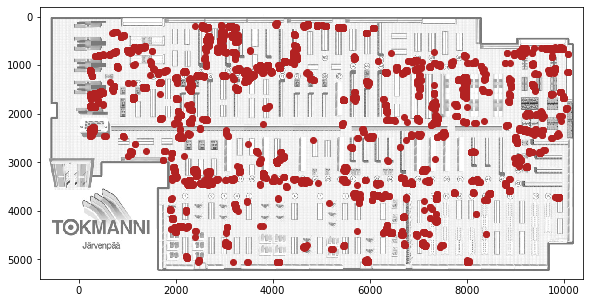

In [13]:
plt.clf()
img = plt.imread("pic.png")
plt.rcParams['figure.figsize'] = 10, 5
fig, ax = plt.subplots()
ax.imshow(img, extent=[-800, 10400, 5400, -200])
ax.plot(table['x'], table['y'] , 'o', linewidth=0.2, color='firebrick')
plt.show()

# Heatmap

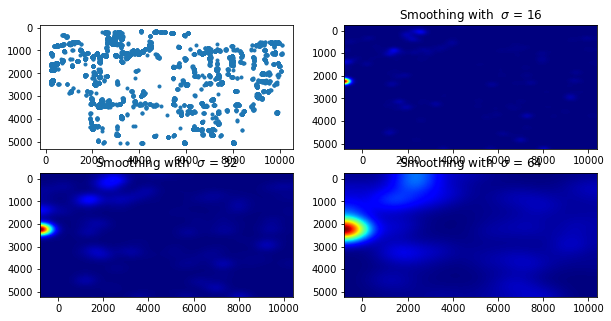

In [14]:
from scipy.ndimage.filters import gaussian_filter
import matplotlib.cm as cm

x = table['X'].tolist()
y = table['Y'].tolist()

def myplot(x, y, s, bins=1000):
    heatmap, xedges, yedges = np.histogram2d(x, y, bins=bins)
    heatmap = gaussian_filter(heatmap, sigma=s)
    return heatmap.T, extent

extent=[-800, 10400, 5220, -250]
img2 = img
fig, axs = plt.subplots(2, 2)

sigmas = [0, 16, 32, 64]
for ax, s in zip(axs.flatten(), sigmas):
    if s == 0:
        ax.invert_yaxis()
        ax.plot(x, y, 'o', linewidth=0.2, markersize=3)
    else:
        img2, extent = myplot(x, y, s)
        ax.imshow(np.flipud(img2), extent=extent, origin='lower', cmap=cm.jet)
        ax.set_title("Smoothing with  $\sigma$ = %d" % s)

plt.show()

# Luodaan IPywidgetsin avulla graafinen käyttöliittymä

In [15]:
import matplotlib.pyplot as plt
import datetime
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
ulostulo = widgets.Output()

@interact
def nayta_arvot_yli(column1='x', x = 5000, column2='y', y = 2500, column3='timestamp', timestamp='2019-07-07 13:05:08.078133+00:00'):
    def kasittele_tapahtuma(muutos):
        ulostulo.clear_output(wait=True)
        with ulostulo:
            #if muutos['type'] == 'change' and muutos['name'] == 'value':
                #print("changed to %s" % muutos['new'])
            
            #x = np.array([df.drop(df[(df.x < x)].index).x])
            #y = np.array([df.drop(df[(df.y < y)].index).y])
            if muutos['new'] == 'x': # Valitaan alasvetovalikosta x-akseli
                
                # Valitaan halutut koordinaatit x:n arvon perusteella ja tehdään niistä Numpy-taulukko.
                x1 = np.array([table.loc[table[column1] > x].x])
                y1 = np.array([table.loc[table[column1] > x].y])
                
                # Plotataan kuva.
                img = plt.imread("pic.png")
                plt.rcParams['figure.figsize'] = 10, 5
                fig, ax = plt.subplots()
                ax.imshow(img, extent=[-800, 10400, 5400, -200])
                ax.plot(x1, y1, 'o') # linewidth=1, color='firebrick'
                plt.show()
                
            elif muutos['new'] == 'y': # Valitaan alasvetovalikosta y-akseli
                # Valitaan halutut koordinaatit y:n arvon perusteella ja tehdään niistä Numpy-taulukko.
                y2 = np.array([table.loc[table[column2] > y].y])
                x2 = np.array([table.loc[table[column2] > y].x])
                
                # Plotataan kuva.
                img = plt.imread("pic.png")
                plt.rcParams['figure.figsize'] = 10, 5
                fig, ax = plt.subplots()
                ax.imshow(img, extent=[-800, 10400, 5400, -200])
                ax.plot(x2, y2, 'o')
                plt.show()
                
            elif muutos['new'] == 'timestamp': # Valitaan alasvetovalikosta aikaleima
                # Tässä yritetään samaa kuin x- ja y-koordinaattien kohdalla, mutta se ei vielä onnistu.
                aika = table.loc[int(table[column3].to_timestamp) > timestamp]
                x3 = np.array([aika.item().total_seconds() > timestamp.item().total_seconds().x])
                y3 = np.array([aika.item().total_seconds() > timestamp.item().total_seconds().y])
                
                # Plotataan kuva.
                img = plt.imread("pic.png")
                plt.rcParams['figure.figsize'] = 10, 5
                fig, ax = plt.subplots()
                ax.imshow(img, extent=[-800, 10400, 5400, -200])
                ax.plot(x3, y3, 'o')
                plt.show()
        
            #print(x1.size)
            #print(y1.size)
            #return (x1, y1)
        
    valitse_akseli = widgets.Dropdown(
        options=['x', 'y', 'timestamp'],
        value=None,
        description='Akseli:',
    )
    valitse_akseli.observe(kasittele_tapahtuma) # Kiinnitetään tapahtumakäsittelijö alasvetovalikkoon.
    
    # Tehdään alasvetovalikko ja siitä tehtävän valinnan tuloksena piirtyvä kuva näkyviksi.
    display(valitse_akseli)
    display(ulostulo)

Dropdown(description='Akseli:', options=('x', 'y', 'timestamp'), value=None)

Output()